<a href="https://colab.research.google.com/github/ruthelphor/Projet_court_AIAO_M2BI/blob/main/Projet_localization_yamadjako.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importation des modules nécessaires**



In [ ]:
!pip install scikeras
!pip install tensorflow

In [ ]:
import os
import requests
import numpy as np
from tqdm import tqdm
import zipfile
import pandas as pd
from pandas import read_csv

from sklearn import preprocessing
from keras.utils import to_categorical  # Utiliser directement to_categorical depuis keras.utils

# Potentially also calculate class weights
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten
from scikeras.wrappers import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
# Utily function from keras
#from keras.utils import np_utils
# Plot model
#from keras.utils import plot_model
# Optimizers
from tensorflow.keras import optimizers

# Useful Sklearn library
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics

from keras.utils import plot_model

**Téléchargement et traitement des données**

In [ ]:
print("####### LOCALIZATION")

def download_data():
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)

####### LOCALIZATION


In [ ]:
# Call the function to download and unzip the data
download_data()

**Chargement et visualisation des données**

In [ ]:
# Data treatment
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
X_train = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Print these to visualize.
print("Shape of dataset X")
print(X_train.shape)
print("Shape of dataset Y")
print(Y.shape)
print("Shape of dataset Mask")
print(mask_train.shape)

Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)
Shape of dataset Mask
(2423, 400)


**Prétraitement des labels**

In [ ]:
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = to_categorical(classes_Y)

print("First 5 rows of X_train:\n", X_train[:5])
print("First 5 elements of Y (original):\n", Y[:5])
print("First 5 rows of mask_train:\n", mask_train[:5])
print("First 5 rows of one-hot encoded Y:\n", onehot_Y[:5])


First 5 rows of X_train:
 [[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0. 

**Analyse des statistiques sur les données**


In [ ]:
df = pd.DataFrame(X_train[:, :, 0])  # Analyze the first feature (index 0 in the third dimension)
stats = df.describe()
print(stats)


               0            1            2            3            4    \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000   
mean      0.021865     0.205510     0.099270     0.075233     0.088902   
std       0.114765     0.298014     0.175479     0.142319     0.156582   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.050000     0.020000     0.020000     0.030000   
75%       0.000000     0.300000     0.120000     0.090000     0.100000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000  ...   
mean      0.085184     0.093553     0.089930     0.100896     0.099030  ...   
std       0.145490     0.159008     0.150393     0.156734     0.152685  ...   
min       0.00000

**t-SNE pour visualiser les données**

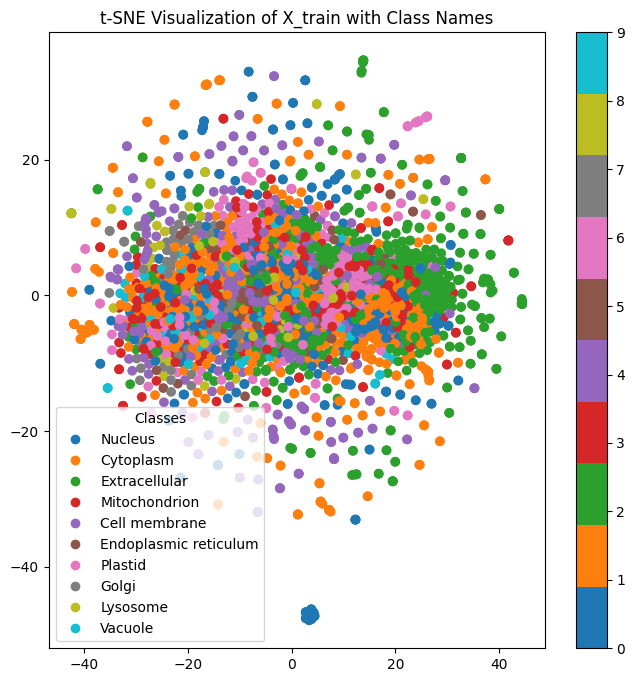

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Définir les noms des classes (par exemple, pour un jeu de données de chiffres manuscrits 0-9)
class_names = ["Nucleus", "Cytoplasm", "Extracellular", "Mitochondrion", "Cell membrane", "Endoplasmic reticulum", "Plastid", "Golgi", "Lysosome", "Vacuole"]

# Applatir X_train
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train_flattened)

# Encodage des labels
y_train_encoded = classes_Y

# Visualiser les résultats de t-SNE
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_encoded, cmap='tab10')

# Ajouter une légende avec les noms des classes
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title="Classes")

plt.colorbar()
plt.title('t-SNE Visualization of X_train with Class Names')
plt.show()


**Barplot pour visualiser la distribution des classes**

<ipython-input-106-713c15dee700>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=counts, palette="viridis")  # Utilisation des noms des classes


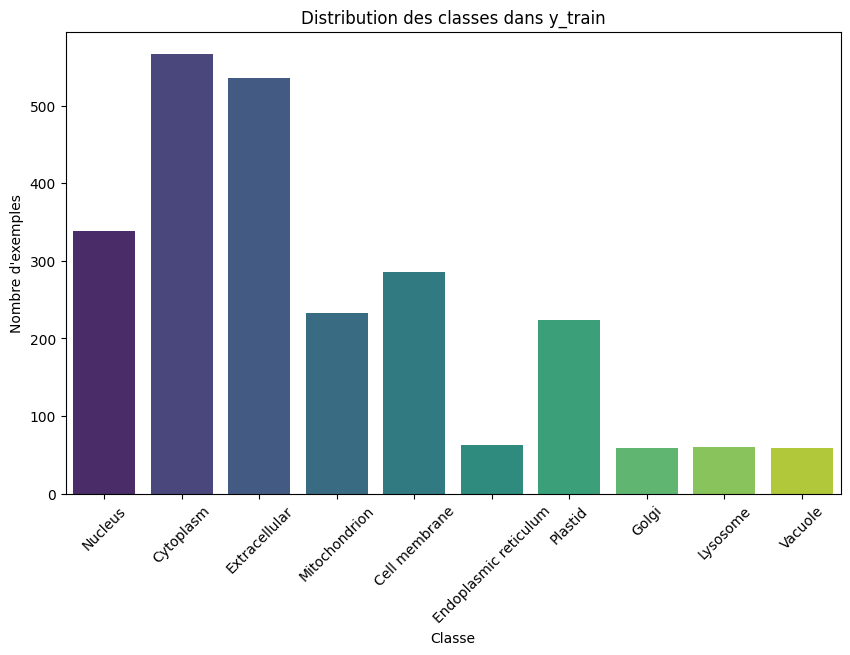

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Les noms des classes
class_labels = ["Nucleus", "Cytoplasm", "Extracellular", "Mitochondrion", "Cell membrane",
                "Endoplasmic reticulum", "Plastid", "Golgi", "Lysosome", "Vacuole"]

# Compter la répartition des classes
unique, counts = np.unique(y_train_encoded, return_counts=True)

# Créer un barplot de la répartition des classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=counts, palette="viridis")  # Utilisation des noms des classes
plt.title("Distribution des classes dans y_train")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=45)  # Rotation des labels pour une meilleure lisibilité
plt.show()



In [ ]:
# Summary of X data and y data to predict

# X : X_train
# Y : onehot_Y


print(X_train[0].shape)
print(mask_train[0].shape)

(400, 20)
(400,)


**Modèle CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense

# Définition du modèle CNN avec Conv1D
def cnn_model(input_shape, num_classes):
    model = Sequential()

    # Première couche Conv1D avec 64 filtres
    model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Deuxième couche Conv1D avec 16 filtres
    model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())

    # Couche d'aplatissement (flatten)
    model.add(Flatten())

    # Couche dense de sortie pour la classification avec 10 classes
    model.add(Dense(num_classes, activation='softmax'))

    # Compilation du modèle
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Spécifiez les dimensions d'entrée et le nombre de classes
input_shape = (400, 20)
num_classes = 10

In [ ]:
# Construire le modèle
cnn_model = cnn_model(input_shape, num_classes)

print(f'{cnn_model.summary()}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)                   │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 398, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 398, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 396, 16)             │           3,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 396, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 6336)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │          63,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,682 (276.10 KB)

 Trainable params: 70,522 (275.48 KB)

 Non-trainable params: 160 (640.00 B)

None


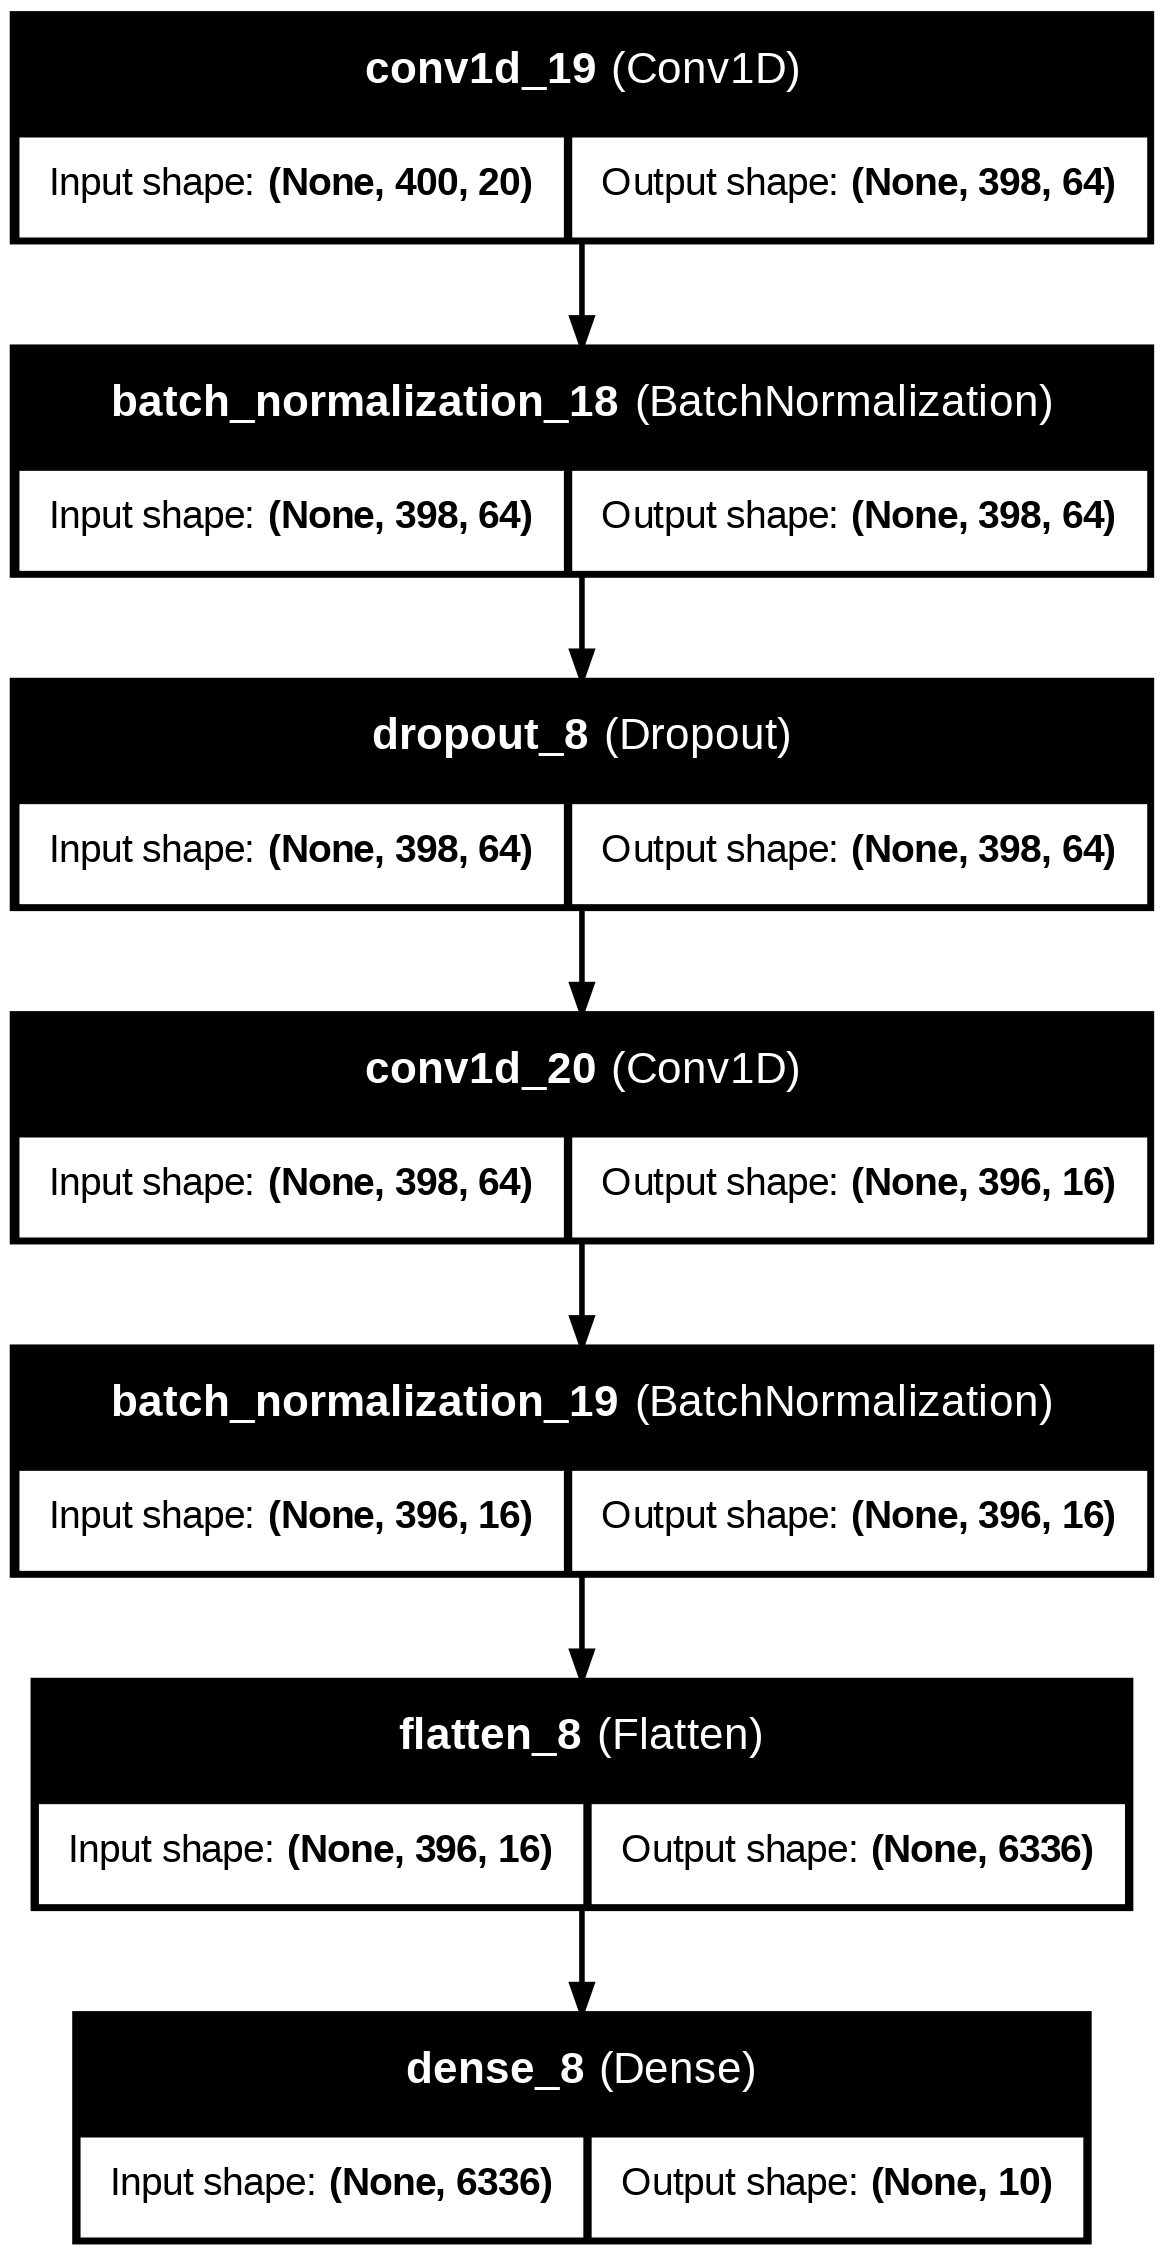

In [ ]:
plot_model(cnn_model, to_file="model.png",show_shapes=True, show_layer_names=True)

In [ ]:
# Entraîner le modèle CNN
history = cnn_model.fit(X_train, onehot_Y, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.3302 - loss: 2.2317 - val_accuracy: 0.2536 - val_loss: 2.2691
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8176 - loss: 0.5628 - val_accuracy: 0.2062 - val_loss: 3.0318
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9373 - loss: 0.2263 - val_accuracy: 0.2619 - val_loss: 3.1513
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9733 - loss: 0.1137 - val_accuracy: 0.2763 - val_loss: 3.0709
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9898 - loss: 0.0797 - val_accuracy: 0.3340 - val_loss: 2.6013
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9909 - loss: 0.0731 - val_accuracy: 0.4289 - val_loss: 1.9750
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9961 - loss: 0.0417 - val_accuracy: 0.5093 - val_loss: 1.4720
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9984 - loss: 0.0302 - val_accuracy: 0.6474 -

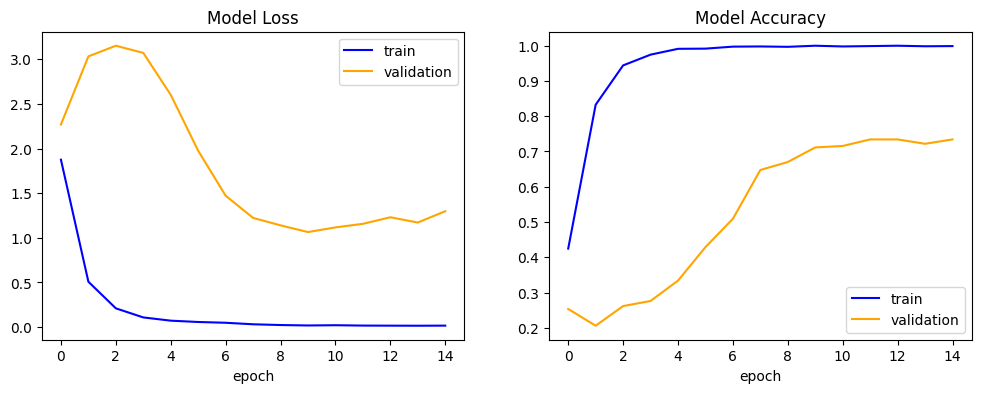

In [ ]:
plt.figure(figsize=(12, 4))
# plot loss
plt.subplot(121)
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

**Division des données**

In [ ]:
from sklearn.model_selection import train_test_split

# Use X_train instead of features
X_train, X_test, y_train, y_test = train_test_split(X_train, onehot_Y, test_size=0.2, random_state=42)

# Afficher les dimensions des jeux de données divisés
print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Train set shape: (1938, 400, 20), (1938, 10)
Test set shape: (485, 400, 20), (485, 10)


In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9325 - loss: 0.3516


In [ ]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

y_test_classes = np.argmax(y_test,axis = 1)
y_test_classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([3, 0, 1, 9, 1, 1, 3, 4, 5, 1, 2, 4, 6, 7, 9, 4, 1, 5, 2, 6, 1, 4,
       6, 1, 0, 2, 9, 0, 2, 6, 3, 2, 6, 3, 6, 1, 0, 8, 1, 2, 1, 3, 4, 4,
       3, 2, 1, 2, 6, 4, 2, 1, 2, 6, 6, 0, 3, 0, 0, 6, 1, 2, 2, 4, 2, 1,
       2, 1, 4, 4, 4, 6, 0, 2, 4, 3, 3, 3, 0, 4, 4, 1, 1, 2, 1, 1, 6, 1,
       1, 0, 6, 7, 3, 2, 1, 0, 0, 2, 2, 0, 2, 2, 1, 5, 6, 6, 5, 2, 1, 2,
       1, 9, 3, 2, 2, 0, 1, 2, 3, 2, 1, 3, 2, 2, 0, 1, 9, 0, 2, 0, 3, 0,
       3, 1, 0, 3, 6, 4, 3, 2, 2, 6, 5, 6, 1, 6, 4, 2, 2, 6, 0, 2, 1, 4,
       2, 1, 4, 8, 1, 4, 0, 2, 1, 2, 1, 0, 2, 5, 2, 1, 2, 2, 1, 1, 2, 9,
       3, 1, 0, 3, 1, 2, 6, 0, 1, 2, 6, 6, 0, 1, 6, 1, 4, 0, 2, 0, 2, 6,
       3, 1, 1, 2, 1, 2, 0, 9, 4, 1, 1, 9, 6, 0, 3, 0, 2, 1, 1, 2, 3, 4,
       6, 1, 1, 0, 1, 0, 3, 4, 3, 1, 5, 2, 2, 9, 1, 2, 2, 2, 9, 8, 0, 2,
       1, 0, 2, 2, 4, 1, 1, 3, 5, 4, 0, 1, 2, 5, 0, 4, 2, 0, 1, 6, 1, 0,
       2, 2, 1, 2, 2, 2, 3, 2, 9, 2, 8, 1, 9, 3, 1, 5, 0, 2, 1, 4, 2, 3,
       2, 1, 0, 1, 0, 2, 0, 2, 3, 3, 6, 3, 2, 4, 8,

<Axes: >

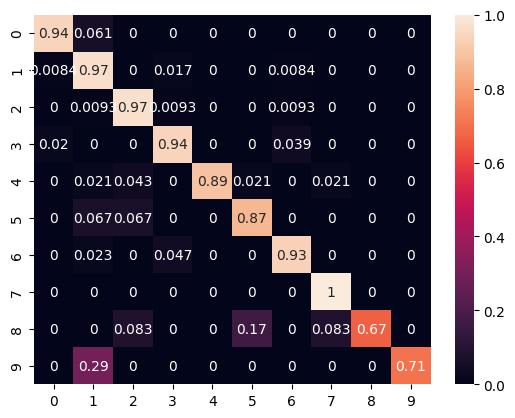

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes, normalize="true"), annot=True)

<Axes: >

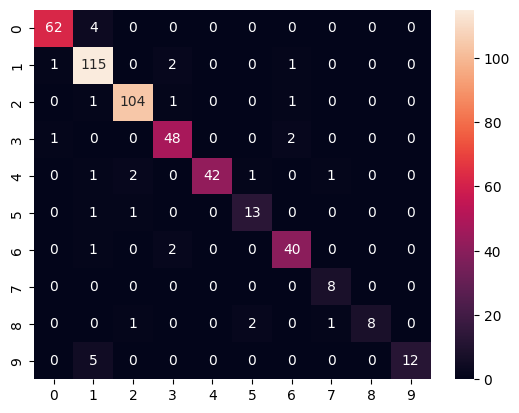

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d')

Weighting class

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(Y),
                                        y = Y
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



In [ ]:
from tensorflow.keras import callbacks

callback = callbacks.EarlyStopping(
    monitor='val_weighted_accuracy',  # Surveiller la métrique de précision pondérée
    patience=5,  # Arrêt anticipé après 5 epochs sans amélioration
    mode='max'   # Cherche à maximiser la métrique (précision pondérée)
)

In [ ]:
# Définition du modèle CNN avec Conv1D
def cnn_model(input_shape, num_classes):
    model = Sequential()

    # Première couche Conv1D avec 64 filtres
    model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Deuxième couche Conv1D avec 16 filtres
    model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())

    # Couche d'aplatissement (flatten)
    model.add(Flatten())

    # Couche dense de sortie pour la classification avec 10 classes
    model.add(Dense(num_classes, activation='softmax'))

    # Compilation du modèle
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Spécifiez les dimensions d'entrée et le nombre de classes
input_shape = (400, 20)  # Correct input shape for Conv1D
num_classes = 10

# Création du modèle CNN
model_cnn_w = cnn_model(input_shape=input_shape, num_classes=num_classes)

# Afficher le résumé du modèle
print(model_cnn_w.summary())

# Entraîner le modèle (en supposant que X_train et y_train soient définis correctement)
history = model_cnn_w.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, class_weight=class_weights)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 398, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 398, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 396, 16)             │           3,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 396, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 6336)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │          63,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,682 (276.10 KB)

 Trainable params: 70,522 (275.48 KB)

 Non-trainable params: 160 (640.00 B)

None
Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1875 - loss: 2.8295 - val_accuracy: 0.0206 - val_loss: 3.3916
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6569 - loss: 0.7494 - val_accuracy: 0.0180 - val_loss: 4.3206
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8885 - loss: 0.2914 - val_accuracy: 0.0412 - val_loss: 4.5845
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9375 - loss: 0.1700 - val_accuracy: 0.0851 - val_loss: 4.7820
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9675 - loss: 0.1038 - val_accuracy: 0.1005 - val_loss: 4.3203
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9826 - loss: 0.0674 - val_accuracy: 0.1108 - val_loss: 4.2848
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9897 - loss: 0.0476 - val_accuracy: 0.1753 - val_loss: 3.3931
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9892 - loss: 0.0440 - val_accuracy: 0.273

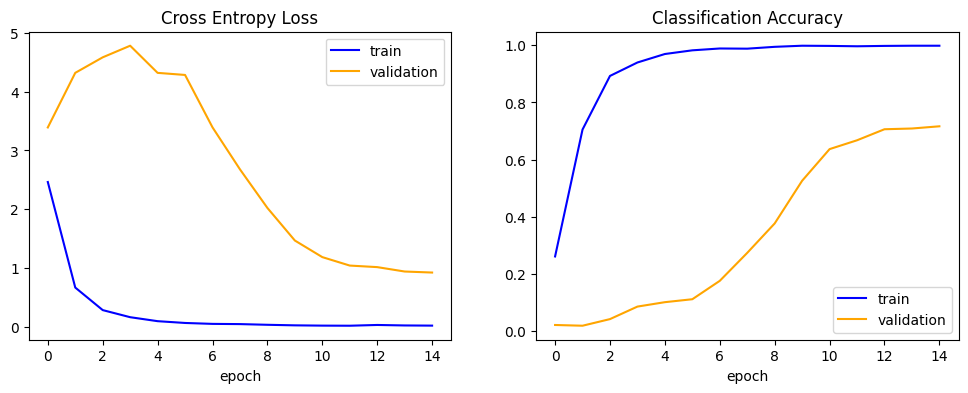

In [ ]:
plt.figure(figsize=(12, 4))
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

In [ ]:
model_cnn_w.evaluate(X_test,y_test)

y_pred = model_cnn_w.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)

y_test_classes = np.argmax(y_test,axis = 1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7011 - loss: 0.9965
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
y_pred = model_cnn_w.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

y_test_classes = np.argmax(y_test,axis = 1)
y_test_classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([3, 0, 1, 9, 1, 1, 3, 4, 5, 1, 2, 4, 6, 7, 9, 4, 1, 5, 2, 6, 1, 4,
       6, 1, 0, 2, 9, 0, 2, 6, 3, 2, 6, 3, 6, 1, 0, 8, 1, 2, 1, 3, 4, 4,
       3, 2, 1, 2, 6, 4, 2, 1, 2, 6, 6, 0, 3, 0, 0, 6, 1, 2, 2, 4, 2, 1,
       2, 1, 4, 4, 4, 6, 0, 2, 4, 3, 3, 3, 0, 4, 4, 1, 1, 2, 1, 1, 6, 1,
       1, 0, 6, 7, 3, 2, 1, 0, 0, 2, 2, 0, 2, 2, 1, 5, 6, 6, 5, 2, 1, 2,
       1, 9, 3, 2, 2, 0, 1, 2, 3, 2, 1, 3, 2, 2, 0, 1, 9, 0, 2, 0, 3, 0,
       3, 1, 0, 3, 6, 4, 3, 2, 2, 6, 5, 6, 1, 6, 4, 2, 2, 6, 0, 2, 1, 4,
       2, 1, 4, 8, 1, 4, 0, 2, 1, 2, 1, 0, 2, 5, 2, 1, 2, 2, 1, 1, 2, 9,
       3, 1, 0, 3, 1, 2, 6, 0, 1, 2, 6, 6, 0, 1, 6, 1, 4, 0, 2, 0, 2, 6,
       3, 1, 1, 2, 1, 2, 0, 9, 4, 1, 1, 9, 6, 0, 3, 0, 2, 1, 1, 2, 3, 4,
       6, 1, 1, 0, 1, 0, 3, 4, 3, 1, 5, 2, 2, 9, 1, 2, 2, 2, 9, 8, 0, 2,
       1, 0, 2, 2, 4, 1, 1, 3, 5, 4, 0, 1, 2, 5, 0, 4, 2, 0, 1, 6, 1, 0,
       2, 2, 1, 2, 2, 2, 3, 2, 9, 2, 8, 1, 9, 3, 1, 5, 0, 2, 1, 4, 2, 3,
       2, 1, 0, 1, 0, 2, 0, 2, 3, 3, 6, 3, 2, 4, 8,

<Axes: >

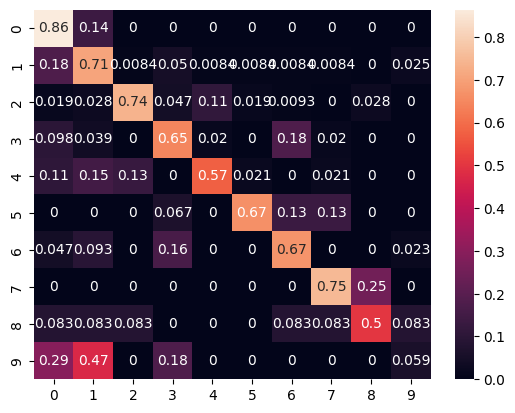

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes, normalize="true"), annot=True)

<Axes: >

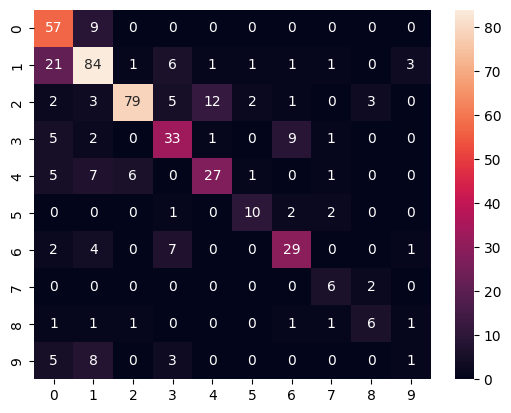

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d')

**Apprentissage avec ResNet**

In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, Flatten, Dense
from keras.layers import AveragePooling1D, Activation, BatchNormalization, Add, Dropout

def residual_module(input, channels):
    stride = 1
    kernel_size = 3
    x_shortcut = input

    # Adapter la dimension du chemin court si nécessaire
    if input.shape[-1] != channels:
        x_shortcut = Conv1D(channels, (1), padding='same', strides=stride)(x_shortcut)

    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv1D(channels, (1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
    output = Add()([x, x_shortcut])
    return output

def construct_resnet():
    n_residual = 2
    print("Simple residual network with {} modules".format(n_residual))

    inputs = Input(shape=(400, 20))

    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 32)

    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)
    flat_1 = Flatten()(gavg_1)

    flat_1 = Dropout(0.4)(flat_1)

    output = Dense(10, activation="softmax")(flat_1)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

    return model


In [ ]:
model_resnet = construct_resnet()
model_resnet.summary()

Simple residual network with 2 modules


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 400, 20)        │             80 │ input_layer_10[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 400, 32)        │            672 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 400, 32)        │            128 │ conv1d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 400, 32)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 400, 32)        │          3,104 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 400, 32)        │            672 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 400, 32)        │              0 │ conv1d_25[0][0],       │
│                           │                        │                │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 400, 32)        │            128 │ add_2[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 400, 32)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 400, 32)        │          1,056 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 400, 32)        │            128 │ conv1d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 400, 32)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)        │ (None, 400, 32)        │          3,104 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 400, 32)        │              0 │ conv1d_27[0][0],       │
│                           │                        │                │ add_2[0][0]            │
├──────────────────────

 Total params: 136,762 (534.23 KB)

 Trainable params: 136,530 (533.32 KB)

 Non-trainable params: 232 (928.00 B)

In [ ]:
history_resnet = model_resnet.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=50, class_weight=class_weights)

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.2373 - loss: 2.7577 - val_accuracy: 0.2758 - val_loss: 2.1934
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8073 - loss: 0.4867 - val_accuracy: 0.1289 - val_loss: 2.1836
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9434 - loss: 0.1839 - val_accuracy: 0.1314 - val_loss: 2.2123
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9677 - loss: 0.1013 - val_accuracy: 0.1753 - val_loss: 2.3028
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9862 - loss: 0.0615 - val_accuracy: 0.1443 - val_loss: 2.3491
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9945 - loss: 0.0383 - val_accuracy: 0.1985 - val_loss: 2.3077
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9924 - loss: 0.0381 - val_accuracy: 0.2500 - val_loss: 2.2189
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9962 - loss: 0.0268 - val_accuracy: 0.2784 -

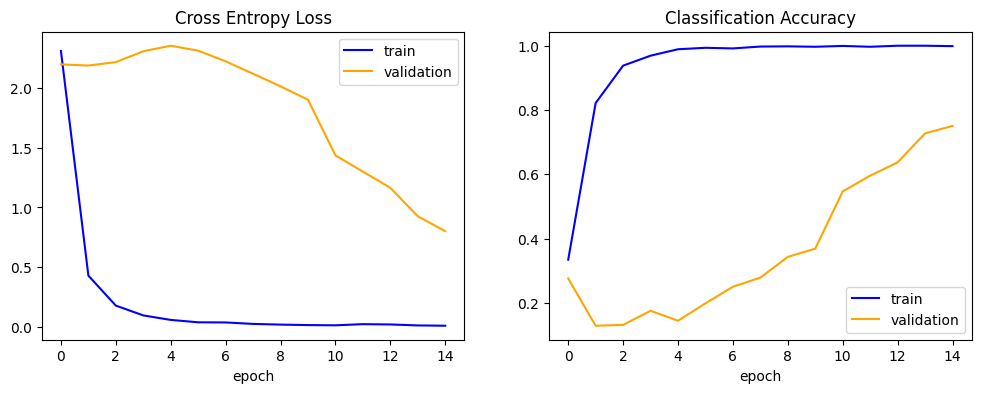

In [ ]:
plt.figure(figsize=(12, 4))
# plot loss
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history_resnet.history['loss'], color='blue', label='train')
plt.plot(history_resnet.history['val_loss'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history_resnet.history['accuracy'], color='blue', label='train')
plt.plot(history_resnet.history['val_accuracy'], color='orange', label='validation')
plt.xlabel('epoch')

plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model_resnet.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7352 - loss: 0.9959


In [ ]:
y_pred = model_resnet.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

y_test_classes = np.argmax(y_test,axis = 1)
y_test_classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([3, 0, 1, 9, 1, 1, 3, 4, 5, 1, 2, 4, 6, 7, 9, 4, 1, 5, 2, 6, 1, 4,
       6, 1, 0, 2, 9, 0, 2, 6, 3, 2, 6, 3, 6, 1, 0, 8, 1, 2, 1, 3, 4, 4,
       3, 2, 1, 2, 6, 4, 2, 1, 2, 6, 6, 0, 3, 0, 0, 6, 1, 2, 2, 4, 2, 1,
       2, 1, 4, 4, 4, 6, 0, 2, 4, 3, 3, 3, 0, 4, 4, 1, 1, 2, 1, 1, 6, 1,
       1, 0, 6, 7, 3, 2, 1, 0, 0, 2, 2, 0, 2, 2, 1, 5, 6, 6, 5, 2, 1, 2,
       1, 9, 3, 2, 2, 0, 1, 2, 3, 2, 1, 3, 2, 2, 0, 1, 9, 0, 2, 0, 3, 0,
       3, 1, 0, 3, 6, 4, 3, 2, 2, 6, 5, 6, 1, 6, 4, 2, 2, 6, 0, 2, 1, 4,
       2, 1, 4, 8, 1, 4, 0, 2, 1, 2, 1, 0, 2, 5, 2, 1, 2, 2, 1, 1, 2, 9,
       3, 1, 0, 3, 1, 2, 6, 0, 1, 2, 6, 6, 0, 1, 6, 1, 4, 0, 2, 0, 2, 6,
       3, 1, 1, 2, 1, 2, 0, 9, 4, 1, 1, 9, 6, 0, 3, 0, 2, 1, 1, 2, 3, 4,
       6, 1, 1, 0, 1, 0, 3, 4, 3, 1, 5, 2, 2, 9, 1, 2, 2, 2, 9, 8, 0, 2,
       1, 0, 2, 2, 4, 1, 1, 3, 5, 4, 0, 1, 2, 5, 0, 4, 2, 0, 1, 6, 1, 0,
       2, 2, 1, 2, 2, 2, 3, 2, 9, 2, 8, 1, 9, 3, 1, 5, 0, 2, 1, 4, 2, 3,
       2, 1, 0, 1, 0, 2, 0, 2, 3, 3, 6, 3, 2, 4, 8,

<Axes: >

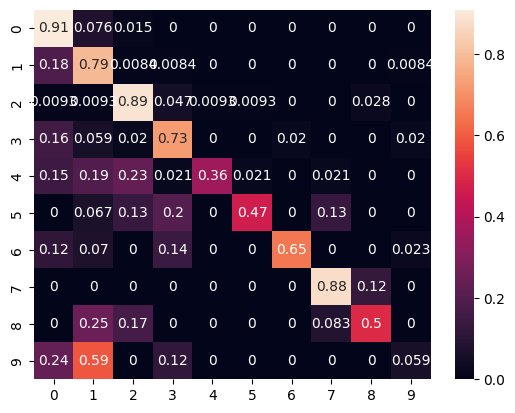

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes, normalize="true"), annot=True)

<Axes: >

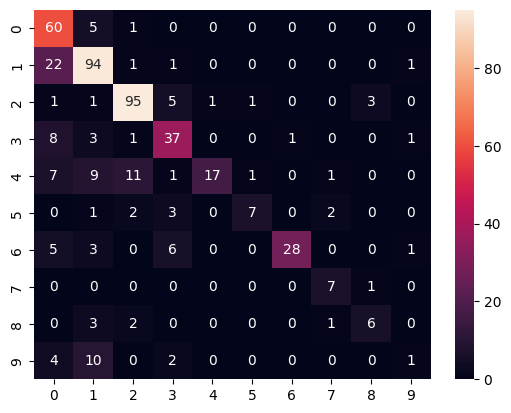

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d')

**Cross_validation sur le modele ResNet avec n_splits = 3**

Simple residual network with 2 modules
Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.2072 - loss: 3.1552 - val_accuracy: 0.2260 - val_loss: 2.2038
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6676 - loss: 0.6995 - val_accuracy: 0.2012 - val_loss: 2.1290
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8979 - loss: 0.2607 - val_accuracy: 0.1796 - val_loss: 2.1559
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9522 - loss: 0.1353 - val_accuracy: 0.1687 - val_loss: 2.1311
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9822 - loss: 0.0834 - val_accuracy: 0.2028 - val_loss: 2.0485
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.9926 - loss: 0.0527 - val_accuracy: 0.1997 - val_loss: 2.0238
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9919 - loss: 0.0373 - val_accuracy: 0.2183 - val_loss: 1.9425
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9965

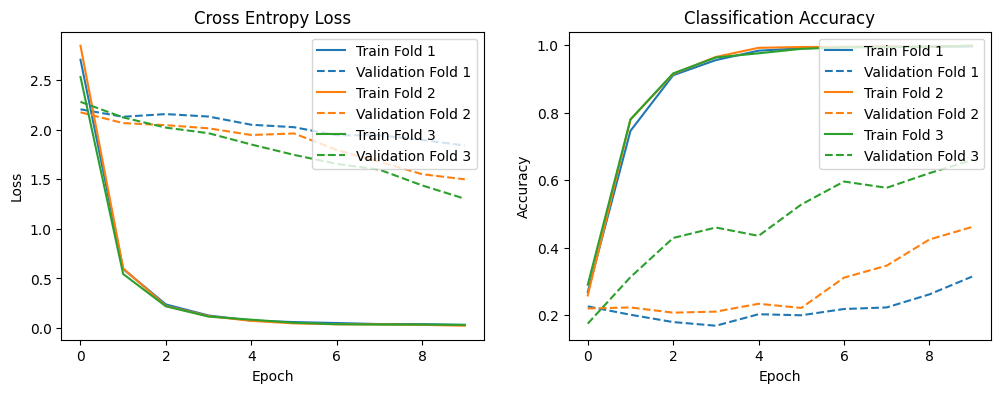

In [ ]:
from sklearn.model_selection import KFold

best_model = None
best_accuracy = 0

kfold = KFold(n_splits=3)

accuracies = []

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for fold, (train_index, val_index) in enumerate(kfold.split(X_train), 1):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = construct_resnet()

    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                        epochs=10, batch_size=50, class_weight=class_weights)

    scores = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(scores[1] * 100)

    # Sauvegarde du meilleur modèle
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model

    color = next(plt.gca()._get_lines.prop_cycler)['color']

    # Loss
    axes[0].plot(history.history['loss'], label=f'Train Fold {fold}', color=color)
    axes[0].plot(history.history['val_loss'], label=f'Validation Fold {fold}', linestyle='--', color=color)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label=f'Train Fold {fold}', color=color)
    axes[1].plot(history.history['val_accuracy'], label=f'Validation Fold {fold}', linestyle='--', color=color)

axes[0].set_title('Cross Entropy Loss')
axes[1].set_title('Classification Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')

plt.show()